## Photometry With MCMC

Having gotten the target files in the previous notebook, I'm going to now use the file `corecomposition/photometry.py` to fetch more photometry from either DES or PANSTARRS. Then, I'll run MCMC with a much better constraint on the temperature which will also give me a better constraint on the radius. 

First, I'll read in the gold, silver, and bronze samples. The gold and silver samples are both subsets of the bronze sample, so I'll do all of the analysis on the bronze table (since that will also analyze the stars in the gold and silver samples). 

In [1]:
### general
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('stefan.mplstyle')

### astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join, vstack, unique

### project-specific
import sys
sys.path.append('../')
sys.path.append('../../')
import corecomposition as cc
import WD_models

gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

In [ ]:
len(bronze)

It seems like most of the ground-based photometry is going to be contaminated by brighter field stars. That means that we'll have to 

In [58]:
vincent_class = Table.read('https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/A+A/682/A5/catalog.dat.gz')
classified = join(bronze, vincent_class, keys_left='wd_source_id', keys_right='GaiaDR3')

In [31]:
classified

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [19]:
targets = vstack([gold, classified])
targets = unique(targets, keys='wd_source_id', keep='last')
ps_photo = cc.photometry.fetch_photometry(targets['wd_source_id'].data)
targets = join(targets, ps_photo, keys_left='wd_source_id', keys_right='source_id', join_type='outer')

In [21]:
with open('../data/cleaned/radius_chains_warwick_gaia.pkl', 'rb') as f:
    gaia_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hdef.pkl', 'rb') as f:
#    one_hdef_chains = pickle.load(f)

#with open('../data/cleaned/radius_chains_ONe_Hrich.pkl', 'rb') as f:
#    one_hrich_chains = pickle.load(f)

In [38]:
import sys
sys.path.append('../')
from corecomposition import interpolator
import corner
import pickle
from tqdm import tqdm

gaia_chains = {}
base_wavl, model_spec, model_spec_low_logg, table = cc.interpolator.utils.build_warwick_da()
build_spec = lambda best_est, distance : 4*np.pi*model_spec((best_est[0], 9)) * ((best_est[1] * 6.957e8) / (distance * 3.086775e16))**2

for j in tqdm(range(len(targets['wd_source_id']))):
    source_id = targets['wd_source_id'][j]
    distance = targets['r_med_geo'][j]
    bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP']
    photomet = np.array([targets['gmag_dereddened'], targets['bpmag_dereddened'], targets['rpmag_dereddened']]).T[j]
    e_photomet = np.array([targets['wd_e_gmag'], targets['wd_e_bpmag'], targets['wd_e_rpmag']]).T[j]
    initial_guess = np.array([targets['Teff'], targets['cmd_radius']]).T[j]

    teff_constraint = np.array([targets['Teff'], targets['e_Teff']]).T[j]
    if np.all(teff_constraint == np.array([0,0])):
        teff_constraint = np.array([None, None])
        initial_guess = np.array([10000, targets['cmd_radius'][j]])

    print(photomet, e_photomet, distance, initial_guess, teff_constraint)

    gaia_model = interpolator.WarwickDAInterpolator(bands)
    # run the MCMC fit using one of the interpolators
    gaia_engine = interpolator.MCMCEngine(gaia_model)
    gaia_flat_chain = gaia_engine.run_mcmc(photomet, e_photomet, distance, initial_guess, teff_constraint)
    gaia_chains[source_id] = gaia_flat_chain

with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'wb') as f:
    pickle.dump(gaia_chains, f)

  0%|          | 0/10 [00:00<?, ?it/s]

[19.23884907 19.3265868  19.24760651] [0.0046625  0.06271348 0.22759461] 167.5027618408203 [1.00000000e+04 7.48175942e-03] [None None]
None None


N/50 = 50;
tau: [238.85714139 239.38478382]


Auto-Correlation Time = 239.3847838191025, additional steps = 9948


 10%|█         | 1/10 [03:05<27:51, 185.72s/it]

[19.82457702 19.92305727 19.77751861] [0.00335602 0.04803275 0.07912166] 178.35098266601562 [1.00000000e+04 6.77754271e-03] [None None]
None None


N/50 = 50;
tau: [184.57503873 183.67646721]


Auto-Correlation Time = 184.57503873156114, additional steps = 7097


 20%|██        | 2/10 [05:40<22:21, 167.69s/it]

[19.46771948 19.61322792 19.00998532] [0.00287245 0.04970009 0.03528614] 86.56997680664062 [6.50600000e+03 7.46525089e-03] [6506  244]
6506 244


N/50 = 50;
tau: [58.95075461 58.83691776]


Auto-Correlation Time = 58.95075460689884, additional steps = 565


 30%|███       | 3/10 [06:22<12:52, 110.34s/it]

[17.23731613 17.20028687 17.38391113] [0.00095818 0.00478089 0.00991014] 61.61625671386719 [1.73000000e+04 4.65161707e-03] [17300   432]
17300 432


 40%|████      | 4/10 [06:55<07:58, 79.77s/it] 

Auto-Correlation Time = 30.082377178236875, additional steps = -936
[18.22249041 18.20595534 18.41972453] [0.00143986 0.01401281 0.02423898] 153.67922973632812 [1.64080000e+04 7.19868427e-03] [16408   889]
16408 889


 50%|█████     | 5/10 [07:26<05:09, 61.99s/it]

Auto-Correlation Time = 38.33063879380204, additional steps = -507
[19.12029722 19.17510911 19.06953206] [0.00167555 0.025341   0.03793036] 142.31100463867188 [1.01780000e+04 7.00188461e-03] [10178   506]
10178 506


N/50 = 50;
tau: [118.18701491 116.85449482]


Auto-Correlation Time = 118.18701491379312, additional steps = 3645


 60%|██████    | 6/10 [08:49<04:37, 69.31s/it]

[18.58383496 18.57350794 18.68873358] [0.00162153 0.01514691 0.01756934] 156.11517333984375 [1.39670000e+04 7.17749731e-03] [13967   832]
13967 832


N/50 = 50;
tau: [115.20141142 108.90810218]


Auto-Correlation Time = 115.20141142441085, additional steps = 3490


 70%|███████   | 7/10 [10:07<03:36, 72.03s/it]

[19.42259916 19.40490126 19.69477526] [0.00256013 0.03538745 0.06859396] 258.0550231933594 [1.00000000e+04 5.97273016e-03] [None None]
None None


N/50 = 50;
tau: [243.23891702 230.00617162]


Auto-Correlation Time = 243.23891701912717, additional steps = 10148


 80%|████████  | 8/10 [12:50<03:22, 101.11s/it]

[19.68607892 19.6957259  19.95050639] [0.00295669 0.03575062 0.07134831] 296.2853698730469 [1.00000000e+04 6.53298911e-03] [None None]
None None


N/50 = 50;
tau: [144.06823474 134.87864163]


Auto-Correlation Time = 144.0682347411712, additional steps = 4991


 90%|█████████ | 9/10 [14:27<01:39, 99.79s/it] 

[19.57090182 19.54634741 19.90523862] [0.00308992 0.03693674 0.17666884] 241.68722534179688 [1.00000000e+04 4.47898949e-03] [None None]
None None


N/50 = 50;
tau: [240.89118673 221.4924616 ]


Auto-Correlation Time = 240.89118672893156, additional steps = 10026


100%|██████████| 10/10 [16:59<00:00, 101.98s/it]


In [39]:
def build_radius_table(chain):
    source_ids = list(chain.keys())
    radius_med = []
    radius_low = []
    radius_high = []

    for wdid in source_ids:
        mcmc = np.percentile(chain[wdid][:,1],[16,50,84])
        unc = np.diff(mcmc)
        radius_med.append(mcmc[1])
        radius_low.append(unc[0])
        radius_high.append(unc[1])

    radius_table = Table()
    radius_table['wd_source_id'] = source_ids
    radius_table['radius_med'] = radius_med
    radius_table['radius_unc_low'] = radius_low
    radius_table['radius_unc_high'] = radius_high
    radius_table['e_radius'] = 0.5 * np.abs(radius_table['radius_unc_high'] + radius_table['radius_unc_low'])
    radius_table['pct_error'] = radius_table['e_radius'] / radius_table['radius_med'] * 100
    return radius_table

radius_table = build_radius_table(gaia_chains)
radius_table.write('../data/cleaned/radius_table_warwick.csv')

In [42]:
targets = join(targets, radius_table, keys='wd_source_id')
targets[['wd_source_id', 'wd_phot_g_mean_mag', 'wd_ra', 'wd_dec', 'cmd_radius', 'SpType', 'source', 'radius_med', 'radius_unc_high', 'radius_unc_low', 'pct_error']]

wd_source_id,wd_phot_g_mean_mag,wd_ra,wd_dec,cmd_radius,SpType,source,radius_med,radius_unc_high,radius_unc_low,pct_error
int64,float64,float64,float64,float64,bytes3,str3,float64,float64,float64,float64
321259125631010688,19.23906898498535,17.00341481267388,35.814406111886065,0.007481759418545218,--,--,0.008628665068979871,0.002165723427152237,0.0017645151227279566,22.77431397823886
2153552814748001792,19.824588775634766,284.65870302124665,57.78819239158009,0.0067775427053977004,--,ps1,0.006694461758338805,0.0008674142153610271,0.000815602487828861,12.570216724992688
3090038517737811712,19.467735290527344,125.10155969827336,1.3826973946792267,0.007465250886754626,DA,ps1,0.007666564686978027,0.0003539586735457137,0.00038156041390796733,4.796927421110723
3121385658671190784,17.237316131591797,92.21438403314589,-0.9974533046455966,0.004651617068459436,DA,ps1,0.004698223247747825,5.368994494544827e-05,5.248346102871681e-05,1.1299314695726852
3249027001465705088,18.224544525146484,53.713824909148926,-3.4247499092447784,0.007198684270318171,DA,ps1,0.007418459822226304,0.00019238008240070846,0.0002003777060200409,2.6471653000263973
4248619071266347648,19.120485305786133,301.35106967868836,5.137256051068365,0.007001884607420573,DA,ps1,0.0070389059401701655,0.0003381768700614924,0.00032215759173280685,4.690604388004762
4750614226039509888,18.58385467529297,46.49363872797763,-47.772247209794116,0.007177497308360124,DA,des,0.006998099890145838,9.774620795047814e-05,0.00012880645644307732,1.6186726965170126
4762592584885748608,19.42276954650879,81.08108195558329,-59.947727725271655,0.0059727301554456215,--,--,0.006461720691338976,0.0007915323235887332,0.0007385901796297953,11.839899744269678
5309155039065680512,19.6861629486084,144.35886329588214,-53.31675538451881,0.006532989105105616,--,--,0.007174590504135092,0.0007704941534923413,0.0006871855954448123,10.158626810108649


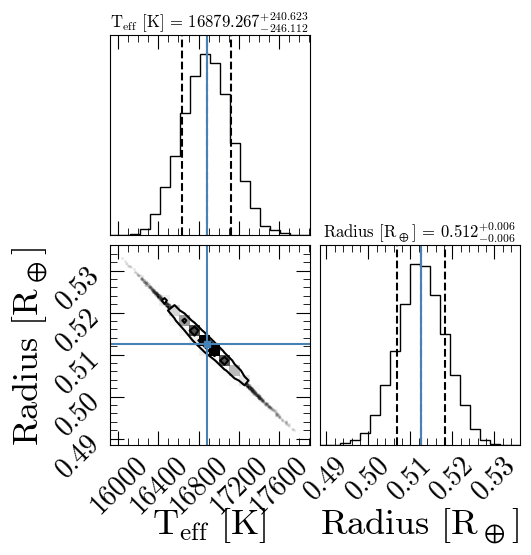

In [43]:
source = 3121385658671190784
labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\oplus]$']
best_est = np.zeros((len(labels)))
unc = []

temp_chain = gaia_chains[source]
temp_chain[:, 1] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(temp_chain, labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

In [5]:
table = Table.read('../data/raw/elbadry.csv')

In [69]:
from astroquery.gaia import Gaia

def get_msrv(catalog):
    stardats = []
    iters = (len(catalog)+2000) // 2000
    for i in range(iters):
            ADQL_CODE1 = """SELECT source_id, radial_velocity, radial_velocity_error
            FROM gaiadr3.gaia_source
            WHERE source_id = {}""".format(catalog['ms_source_id'][0])
            print(ADQL_CODE1)
            stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
    gaia_d1 = vstack(stardats)
    gaia_d1.rename_columns(['SOURCE_ID', 'radial_velocity', 'radial_velocity_error'], ['ms_source_id', 'ms_rv', 'ms_erv'])
    catalog = join(catalog, gaia_d1, keys = 'ms_source_id')
    return catalog

def radius_from_cmd(catalog):
    newton_G = 6.674e-11
    mass_sun = 1.9884e30
    radius_sun = 6.957e8

    model = WD_models.load_model(low_mass_model='Bedard2020',
                                middle_mass_model='Bedard2020',
                                high_mass_model='ONe',
                                atm_type='H',
                                HR_bands=('bp3-rp3', 'G3'))

    bp3_rp3 = catalog['wd_phot_bp_mean_mag'] - catalog['wd_phot_rp_mean_mag']
    G3 = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
    logg = model['HR_to_logg'](bp3_rp3, G3)
    mass = model['HR_to_mass'](bp3_rp3, G3)

    catalog['cmd_radius'] = np.sqrt((newton_G * mass * mass_sun) / (10**logg/100)) / radius_sun
    return catalog

def get_bailerjones(catalog):
    stardats = []
    iters = (len(catalog)+2000) // 2000
    for i in range(iters):
            ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
            FROM gaiadr3.gaia_source as gaia
            JOIN external.gaiaedr3_distance as dist
            ON gaia.source_id = dist.source_id      
            WHERE gaia.source_id = {}""".format(catalog['ms_source_id'][0])
            stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
    gaia_d1 = vstack(stardats)
    gaia_d1.rename_column('source_id', 'ms_source_id')
    catalog = join(catalog, gaia_d1, keys = 'ms_source_id')
    return catalog

test1 = radius_from_cmd(table[table['wd_source_id'] == 4750614226039509888])
test2 = get_msrv(test1)
get_bailerjones(test2)

SELECT source_id, radial_velocity, radial_velocity_error
            FROM gaiadr3.gaia_source
            WHERE source_id = 4750614195976134144


wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2

In [33]:
mask = np.any([bronze['wd_source_id'] == 5309155039065680512, bronze['wd_source_id'] == 5750618956285716480, 
               bronze['wd_source_id'] == 3970162318385391488, bronze['wd_source_id'] == 6844676417977418880, 
               bronze['wd_source_id'] == 5929720226407417728], axis=0)
bronze[mask][['wd_source_id', 'wd_ruwe', 'wd_phot_bp_rp_excess_factor', 'wd_ra', 'wd_dec']]

wd_source_id,wd_ruwe,wd_phot_bp_rp_excess_factor,wd_ra,wd_dec
int64,float64,float64,float64,float64
5309155039065680512,0.9337561130523682,1.048740029335022,144.35886329588214,-53.31675538451881


In [66]:
vincent_class[vincent_class['GaiaDR3'] == 4045706532520186112]

GaiaDR3,SpType,umag,gmag,rmag,imag,zmag,e_Fluxu,e_Fluxg,e_Fluxr,e_Fluxi,e_Fluxz,PDA,PDB,PDC,PDO,PDQ,PDZ,Teff,logg,M,e_Teff,e_logg,e_M,umagcor,e_umagcor,comp,logCHe,logL,e_logL
,,mag,mag,mag,mag,mag,W / (nm m2),W / (nm m2),W / (nm m2),W / (nm m2),W / (nm m2),,,,,,,K,[cm/s2],Msun,K,[cm/s2],Msun,mag,mag,,,[Lsun],[Lsun]
int64,bytes3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int32,float64,float64,float64,float64,bytes27,float64,float64,float64
